In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from scipy.optimize import minimize
import sklearn.linear_model as lm

# plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 3
sns.set()

## Motivating Logistic Regression

In this lecture, we will look at data from the 2017-18 NBA season.

In [2]:
df = pd.read_csv('nba.csv')

In [3]:
df.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22017,1610612744,GSW,Golden State Warriors,21700002,2017-10-17,GSW vs. HOU,L,240,43,...,35,41,34,5,9,17,25,121,-1,1
1,22017,1610612745,HOU,Houston Rockets,21700002,2017-10-17,HOU @ GSW,W,240,47,...,33,43,28,9,5,13,16,122,1,1
2,22017,1610612738,BOS,Boston Celtics,21700001,2017-10-17,BOS @ CLE,L,240,36,...,37,46,24,11,4,12,24,99,-3,1
3,22017,1610612739,CLE,Cleveland Cavaliers,21700001,2017-10-17,CLE vs. BOS,W,240,38,...,41,50,19,3,4,17,25,102,3,1
4,22017,1610612750,MIN,Minnesota Timberwolves,21700011,2017-10-18,MIN @ SAS,L,240,37,...,31,42,23,7,4,13,16,99,-8,1


We are eventually going to want to perform **binary classification**, which is where we predict a 1 or 0. A reasonable thing to want to do given this data is to predict whether or not a team wins. Right now, the `WL` column consists of `"W"` and `"L"`.

In [4]:
df['WL']

0       L
1       W
2       L
3       W
4       L
       ..
2455    W
2456    W
2457    L
2458    W
2459    L
Name: WL, Length: 2460, dtype: object

Let's fix that, so that wins are encoded as `1` and losses are encoded as `0`.

In [5]:
df["WON"] = df["WL"]
df["WON"] = df["WON"].replace("W", 1)
df["WON"] = df["WON"].replace("L", 0)
df.head(5)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,WON
0,22017,1610612744,GSW,Golden State Warriors,21700002,2017-10-17,GSW vs. HOU,L,240,43,...,41,34,5,9,17,25,121,-1,1,0
1,22017,1610612745,HOU,Houston Rockets,21700002,2017-10-17,HOU @ GSW,W,240,47,...,43,28,9,5,13,16,122,1,1,1
2,22017,1610612738,BOS,Boston Celtics,21700001,2017-10-17,BOS @ CLE,L,240,36,...,46,24,11,4,12,24,99,-3,1,0
3,22017,1610612739,CLE,Cleveland Cavaliers,21700001,2017-10-17,CLE vs. BOS,W,240,38,...,50,19,3,4,17,25,102,3,1,1
4,22017,1610612750,MIN,Minnesota Timberwolves,21700011,2017-10-18,MIN @ SAS,L,240,37,...,42,23,7,4,13,16,99,-8,1,0


There is a row for each team and each game in this dataset. It contains the `FG_PCT` (field goal percentage) for each team per game.

In [6]:
df['FG_PCT']

0       0.538
1       0.485
2       0.409
3       0.458
4       0.435
        ...  
2455    0.472
2456    0.553
2457    0.484
2458    0.591
2459    0.402
Name: FG_PCT, Length: 2460, dtype: float64

Let's try and get the field goal percentage difference between two teams in a single game. We will then try and use this value to predict whether or not a team wins, given their field goal percentage difference.

This data cleaning and EDA is not the point of this lecture, but you may want to come back to this and try and understand it.

In [7]:
one_team = df.groupby("GAME_ID").first()
#print(one_team.head())
opponent = df.groupby("GAME_ID").last()
#print(opponent.head())
games = one_team.merge(opponent, left_index = True, right_index = True, suffixes = ["", "_OPP"])
#print(games.head())
games["FG_PCT_DIFF"] = games["FG_PCT"] - games["FG_PCT_OPP"]
games['WON'] = games['WL'].replace('L', 0).replace('W', 1)
games = games[['TEAM_NAME', 'MATCHUP', 'WON', 'FG_PCT_DIFF']]

In [8]:
games.head()

,TEAM_NAME,MATCHUP,WON,FG_PCT_DIFF
GAME_ID,,,,
21700001,Boston Celtics,BOS @ CLE,0,-0.049
21700002,Golden State Warriors,GSW vs. HOU,0,0.053
21700003,Charlotte Hornets,CHA @ DET,0,-0.030
21700004,Indiana Pacers,IND vs. BKN,1,0.041
21700005,Orlando Magic,ORL vs. MIA,1,0.042


Let's start by looking at a `sns.jointplot` of `FG_PCT_DIFF` and `WON`.

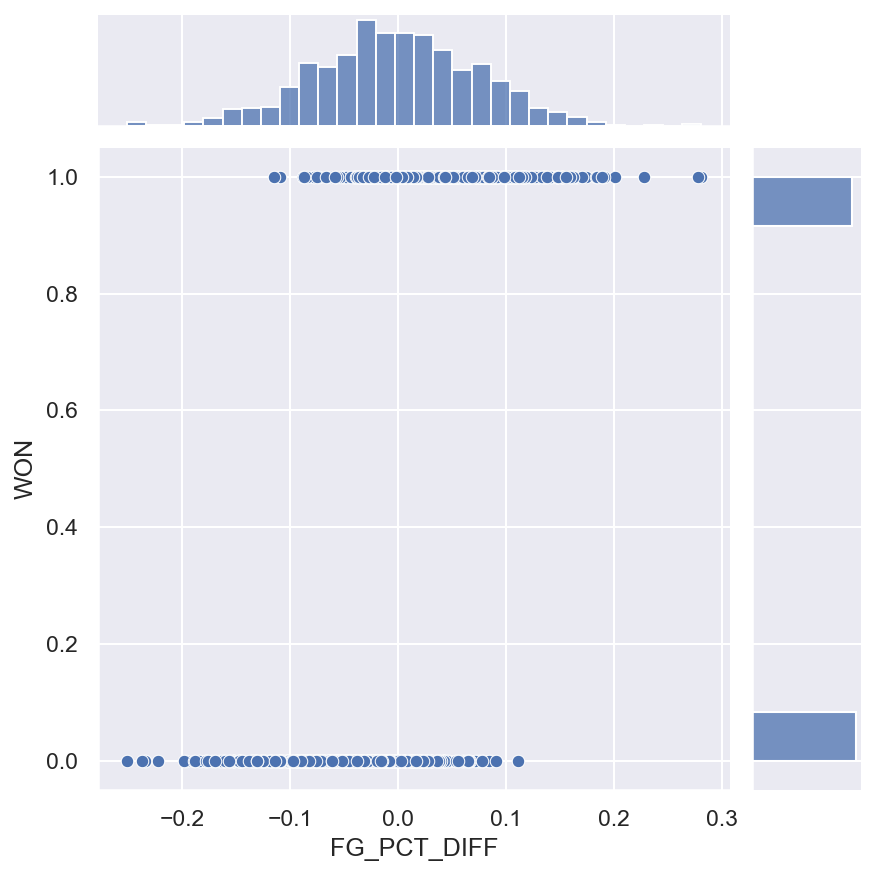

In [9]:
sns.jointplot(data = games, x = "FG_PCT_DIFF", y = "WON");

A reasonable thing to do here might be to model the **probability of winning, given `FG_PCT_DIFF`**.

We already know how to use ordinary least squares, right? Why not use it here?

We'll also jitter the data, to get a better picture of what it looks like. But the line of best fit that's being drawn is on top of the original, non-jittered data.

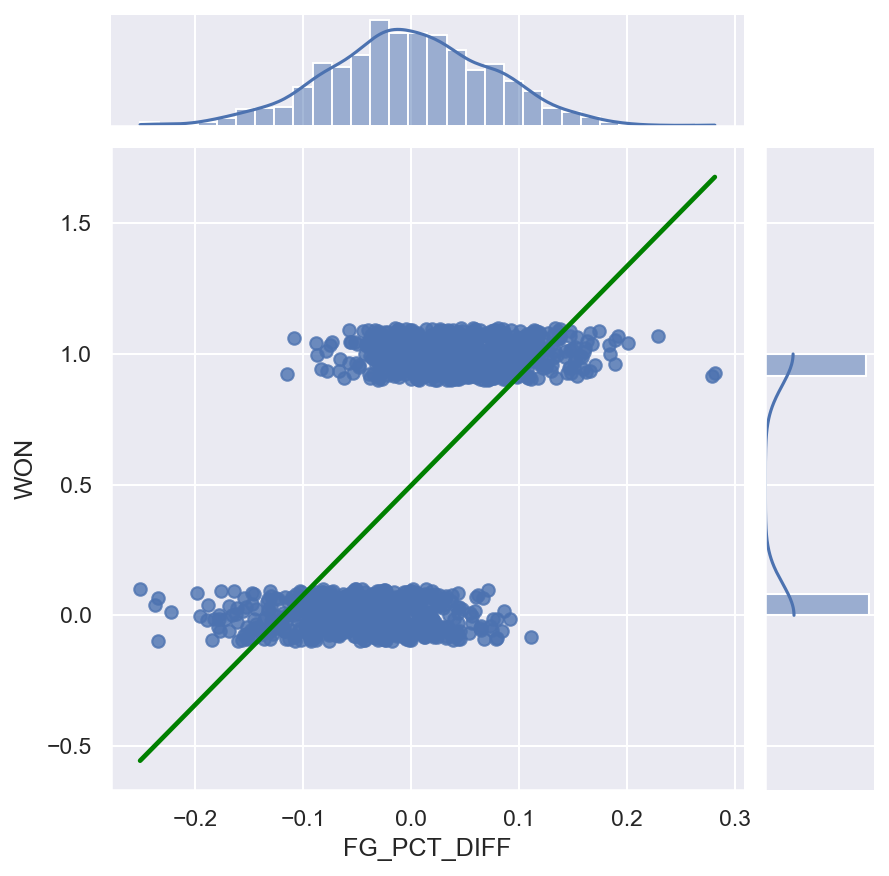

In [10]:
sns.jointplot(data = games, x = "FG_PCT_DIFF", y = "WON", 
              y_jitter = 0.1, 
              kind="reg", 
              ci=False,
              joint_kws={'line_kws':{'color':'green'}});

The green line drawn is a valid model. It is the line that minimizes MSE for this set of $x$ (`FG_PCT_DIFF`) and $y$ (`WON`) data.

But there are some issues:
- The outputs are bigger than 0 and less than 1. How do we interpret that?
- This is very susceptible to outliers. See:

In [11]:
games2 = games.copy()

In [12]:
games2.iloc[0] = ['hello', 'hello', 1, 120]

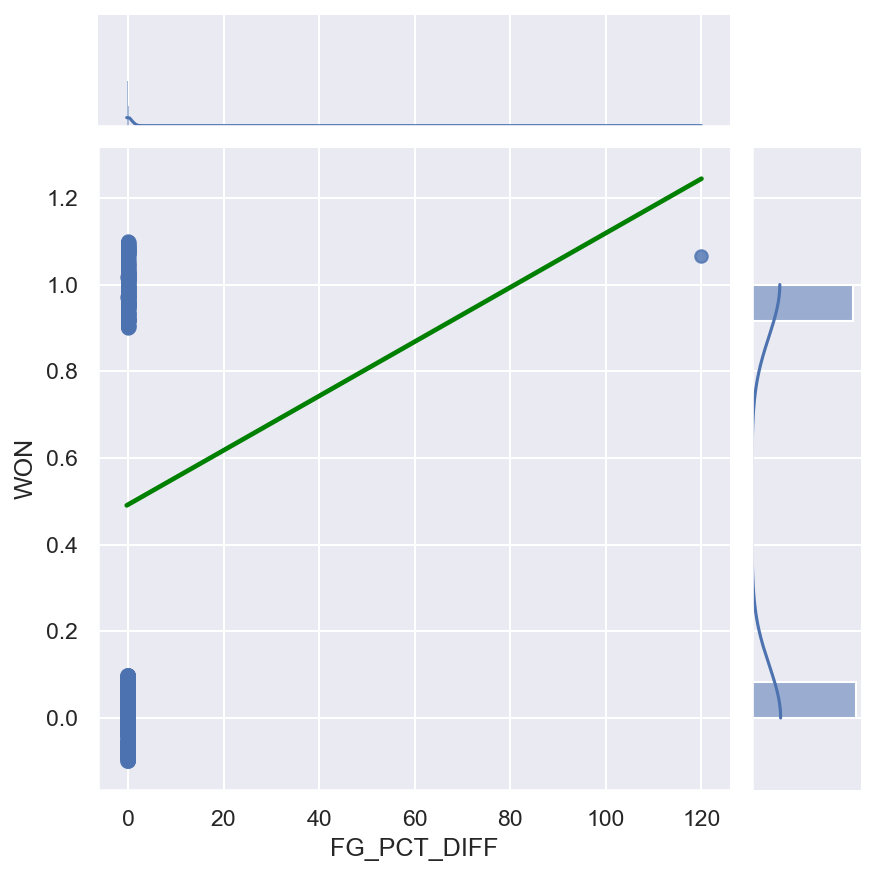

In [13]:
sns.jointplot(data = games2, x = "FG_PCT_DIFF", y = "WON", 
              y_jitter = 0.1, 
              kind="reg", 
              ci=False,
              joint_kws={'line_kws':{'color':'green'}});

We need a better model. Let's try and replicate the **graph of averages** on Simple Linear Regression. Recall, we
- binned the $x$ axis.
- took the average $y$ value for each bin on the $x$ axis.

We will do the same thing here, albeit with slightly different code. Here, we will formally partition the $x$-axis into 20 bins.

In [14]:
bins = pd.cut(games["FG_PCT_DIFF"], 20)

In [15]:
bins

GAME_ID
21700001    (-0.0648, -0.0382]
21700002      (0.0416, 0.0682]
21700003    (-0.0382, -0.0116]
21700004       (0.015, 0.0416]
21700005      (0.0416, 0.0682]
                   ...        
21701226        (0.175, 0.201]
21701227      (0.0682, 0.0948]
21701228       (0.015, 0.0416]
21701229    (-0.0914, -0.0648]
21701230     (-0.118, -0.0914]
Name: FG_PCT_DIFF, Length: 1230, dtype: category
Categories (20, interval[float64, right]): [(-0.252, -0.224] < (-0.224, -0.198] < (-0.198, -0.171] < (-0.171, -0.145] ... (0.175, 0.201] < (0.201, 0.228] < (0.228, 0.254] < (0.254, 0.281]]

In [16]:
games["bin"] = [(b.left + b.right) / 2 for b in bins]
games["bin"]

GAME_ID
21700001   -0.0515
21700002    0.0549
21700003   -0.0249
21700004    0.0283
21700005    0.0549
             ...  
21701226    0.1880
21701227    0.0815
21701228    0.0283
21701229   -0.0781
21701230   -0.1047
Name: bin, Length: 1230, dtype: float64

In [17]:
games

,TEAM_NAME,MATCHUP,WON,FG_PCT_DIFF,bin
GAME_ID,,,,,
21700001,Boston Celtics,BOS @ CLE,0,-0.049,-0.0515
21700002,Golden State Warriors,GSW vs. HOU,0,0.053,0.0549
21700003,Charlotte Hornets,CHA @ DET,0,-0.030,-0.0249
21700004,Indiana Pacers,IND vs. BKN,1,0.041,0.0283
21700005,Orlando Magic,ORL vs. MIA,1,0.042,0.0549
...,...,...,...,...,...
21701226,New Orleans Pelicans,NOP vs. SAS,1,0.189,0.1880
21701227,Oklahoma City Thunder,OKC vs. MEM,1,0.069,0.0815
21701228,LA Clippers,LAC vs. LAL,0,0.017,0.0283


We now know which `"bin"` each game belongs to. We can plot the average `WON` for each bin.

In [18]:
win_rates_by_bin = games.groupby("bin")["WON"].mean()
win_rates_by_bin

bin
-0.2380    0.000000
-0.2110    0.000000
-0.1845    0.000000
-0.1580    0.000000
-0.1315    0.000000
-0.1047    0.033898
-0.0781    0.083333
-0.0515    0.148438
-0.0249    0.363636
 0.0017    0.505747
 0.0283    0.705128
 0.0549    0.792793
 0.0815    0.907407
 0.1079    0.984615
 0.1345    1.000000
 0.1615    1.000000
 0.1880    1.000000
 0.2410    1.000000
 0.2675    1.000000
Name: WON, dtype: float64

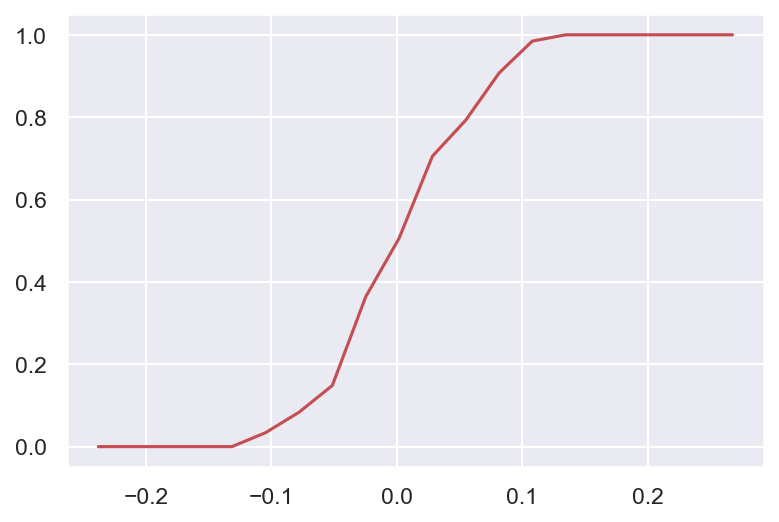

In [19]:
plt.plot(win_rates_by_bin, 'r')

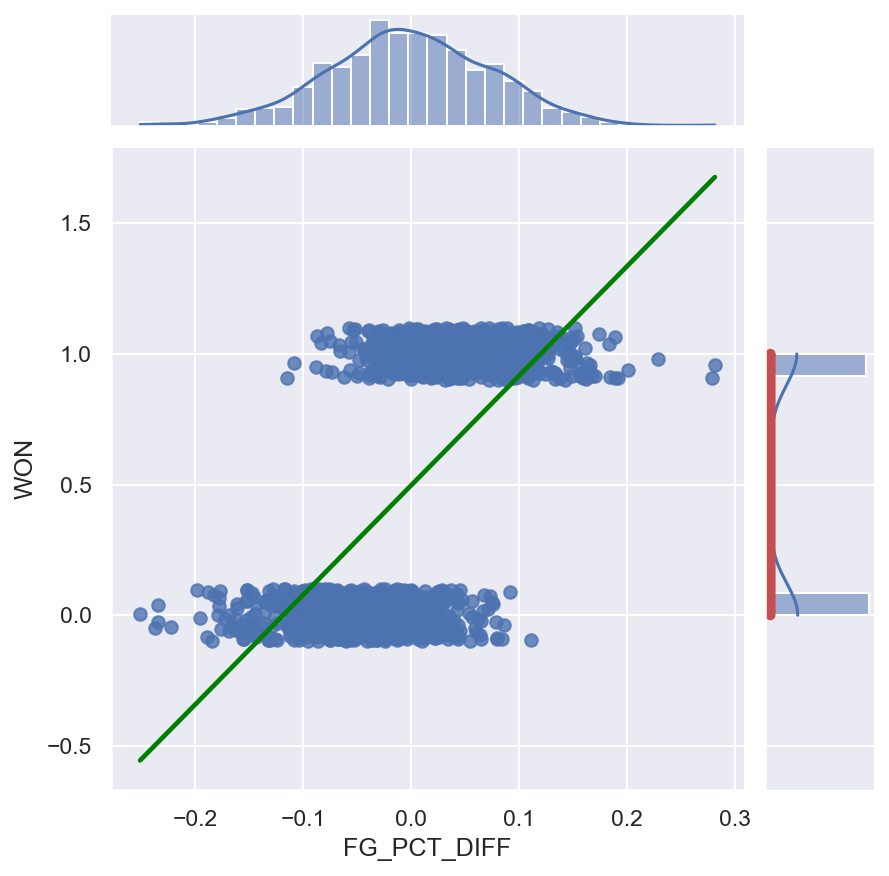

In [20]:
sns.jointplot(data = games, x = "FG_PCT_DIFF", y = "WON", 
              y_jitter = 0.1, 
              kind="reg", 
              ci=False,
              joint_kws={'line_kws':{'color':'green'}});
plt.plot(win_rates_by_bin, 'r', linewidth = 5);

It seems like our red graph of averages does a much better job at matching the data than our simple linear regression line.

**What is this graph of averages plotting?** Since the $y$ axis is only 0s and 1s, and we took the mean of the $y$-values in each bin for a given $x$, the graph of average is plotting the **proportion** of times a team won, given their `FG_PCT_DIFF`. Remember, `WON = 1` each time a team won.

**Logistic regression aims to model the probability of an observation belonging to class 1, given some set of features.**

Then the question is how we model the red curve?

For now, consider these questions:

What are:
1. $P(Y = 1 | X = 0.0283)$? 
2. $P(Y = 0 | X = 0.0283)$? 
3. $\frac{P(Y = 1 | X = 0.0283)}{P(Y = 0 | X = 0.0283)}$? In other words, how many wins are there for each loss?

In [21]:
win_rates_by_bin

bin
-0.2380    0.000000
-0.2110    0.000000
-0.1845    0.000000
-0.1580    0.000000
-0.1315    0.000000
-0.1047    0.033898
-0.0781    0.083333
-0.0515    0.148438
-0.0249    0.363636
 0.0017    0.505747
 0.0283    0.705128
 0.0549    0.792793
 0.0815    0.907407
 0.1079    0.984615
 0.1345    1.000000
 0.1615    1.000000
 0.1880    1.000000
 0.2410    1.000000
 0.2675    1.000000
Name: WON, dtype: float64

The **odds** of an event are defined as the probability that it happens divided by the probability that it doesn't happen.

If some event happens with probability $p$, then $\text{odds}(p) = \frac{p}{1-p}$.

In [22]:
odds_by_bin = win_rates_by_bin / (1 - win_rates_by_bin)
odds_by_bin

bin
-0.2380     0.000000
-0.2110     0.000000
-0.1845     0.000000
-0.1580     0.000000
-0.1315     0.000000
-0.1047     0.035088
-0.0781     0.090909
-0.0515     0.174312
-0.0249     0.571429
 0.0017     1.023256
 0.0283     2.391304
 0.0549     3.826087
 0.0815     9.800000
 0.1079    64.000000
 0.1345          inf
 0.1615          inf
 0.1880          inf
 0.2410          inf
 0.2675          inf
Name: WON, dtype: float64

If we plot the odds of these probabilities, they look exponential:

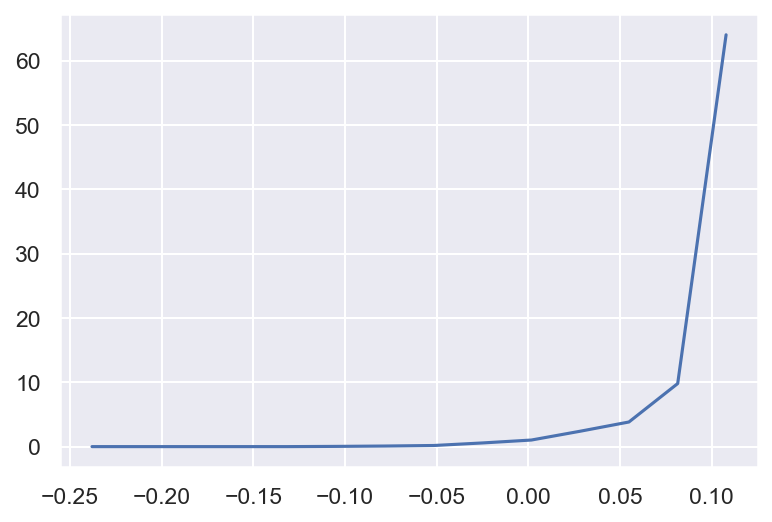

In [23]:
plt.plot(odds_by_bin);

But if we take the log of these odds:

F:\Anaconda\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


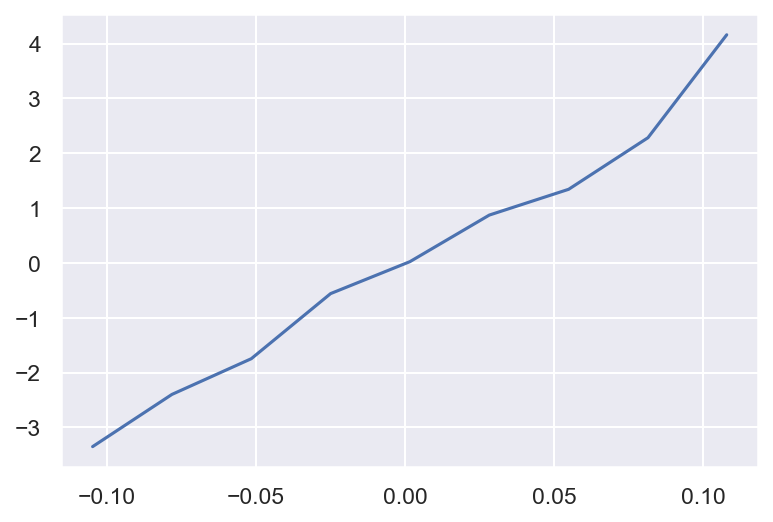

In [24]:
plt.plot(np.log(odds_by_bin));

We noticed that the **log-odds grows linearly with $x$**. 

In the lecture slides, we formalize what this means, and how this allows us to arrive at the `sigma` function above.

## The Logistic Function

In the slides, we show that our model is

$$P(Y = 1 | x) = \sigma(x^T \theta)$$

where $$\sigma(t) = \frac{1}{1 + e^{-t}}$$


In [25]:
def sigma(t):
    return 1 / (1 + np.exp(-t))

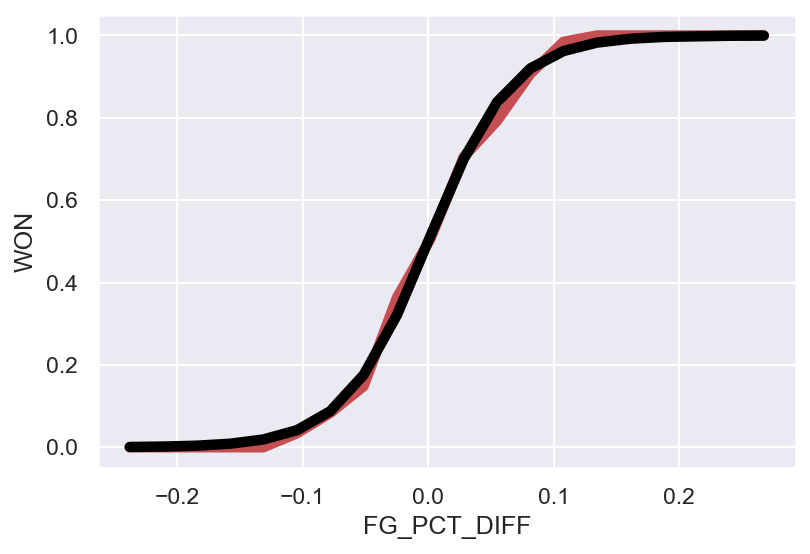

In [26]:
plt.plot(win_rates_by_bin, 'r', linewidth = 5);
x = win_rates_by_bin.index
plt.plot(x, sigma(x * 30), 'black', linewidth = 5);
plt.xlabel('FG_PCT_DIFF')
plt.ylabel('WON');

Let's explore the shape of the logistic function, $\sigma$.

First, the vanilla curve $\sigma(x)$:

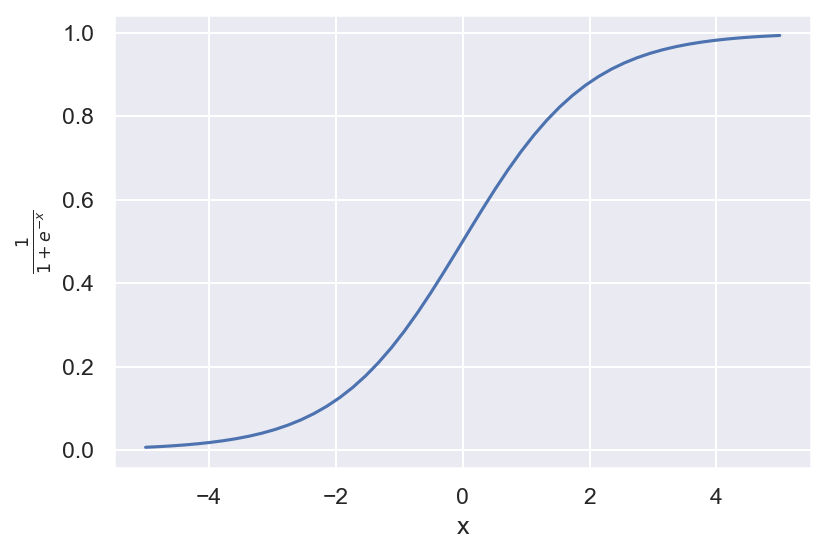

In [27]:
x = np.linspace(-5,5,50)
plt.plot(x, sigma(x));
plt.xlabel('x')
plt.ylabel(r'$\frac{1}{1 + e^{-x}}$');

Now, we look at $\sigma(\theta_1 x)$, for several values of $\theta_1$:

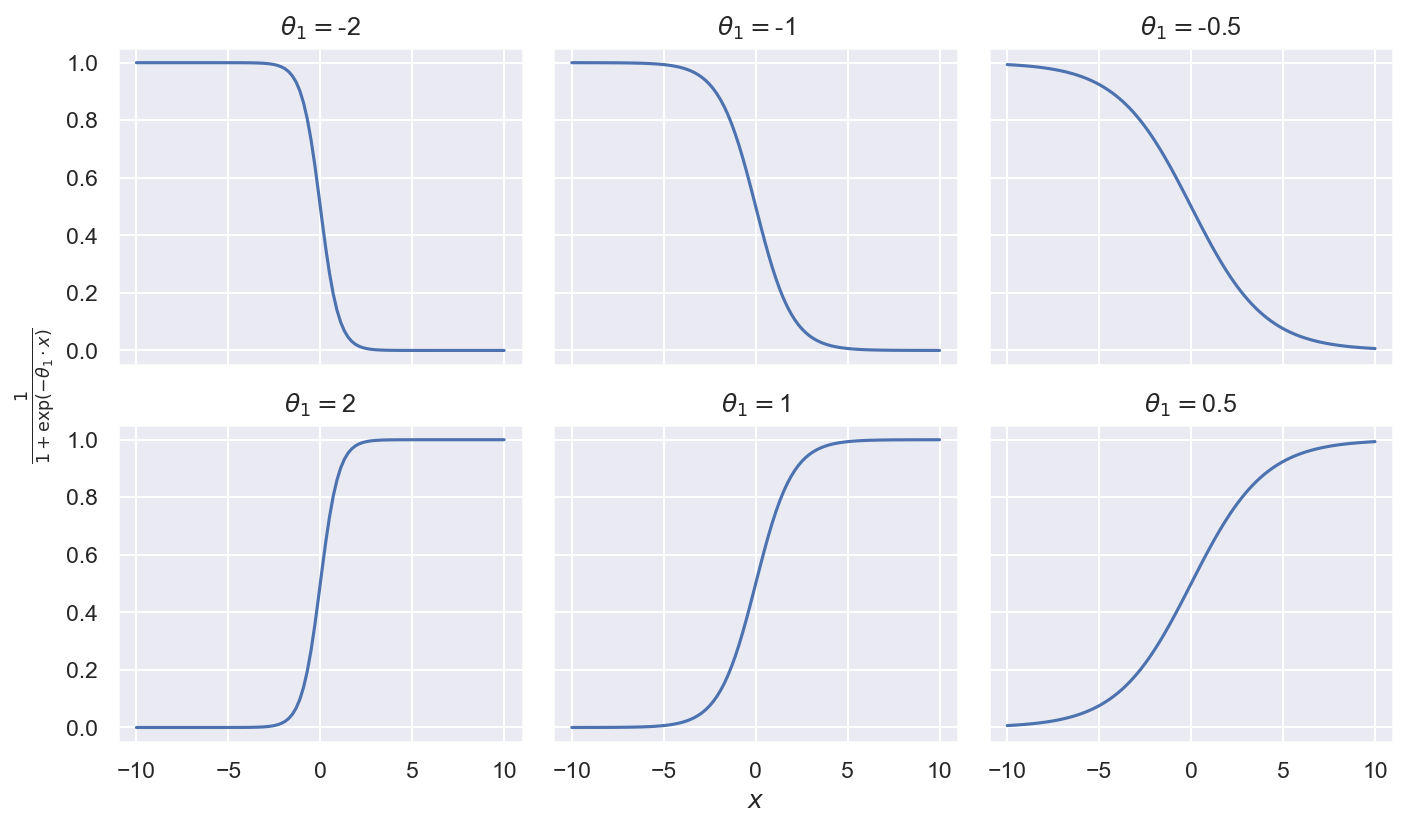

In [28]:
def flatten(li): 
    return [item for sub in li for item in sub]

bs = [-2, -1, -0.5, 2, 1, 0.5]
xs = np.linspace(-10, 10, 100)

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 6))
for ax, b in zip(flatten(axes), bs):
    ys = sigma(xs * b)
    ax.plot(xs, ys)
    ax.set_title(r'$ \theta_1 = $' + str(b))

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False,
                left=False, right=False)
plt.grid(False)
plt.xlabel('$x$')
plt.ylabel(r'$ \frac{1}{1+\exp(-\theta_1 \cdot x)} $')
plt.tight_layout()
# plt.savefig('sigmoids.png')

Let's explore the shape of $\sigma(\theta_0 + \theta_1x)$, for different values of $\theta_0, \theta_1$. There's quite a bit going on here, so let's use `plotly`.

In [29]:
fig = go.Figure()
for theta1 in [-1,1, 5]:
    for theta0 in [-2, 0, 2]:
        fig.add_trace(go.Scatter(name=f"{theta0} + {theta1} x", x=xs, y=sigma(theta0 + theta1*xs)))
fig

## Logistic Regression with Squared Loss

We've chosen a model. It's now time to choose a loss function. Why not squared loss?

In [30]:
def mse_loss_single_arg_nba(theta):
    x = games["FG_PCT_DIFF"]
    y_obs = games["WON"]
    y_hat = sigma(x * theta)
    return np.mean((y_hat - y_obs) ** 2)  

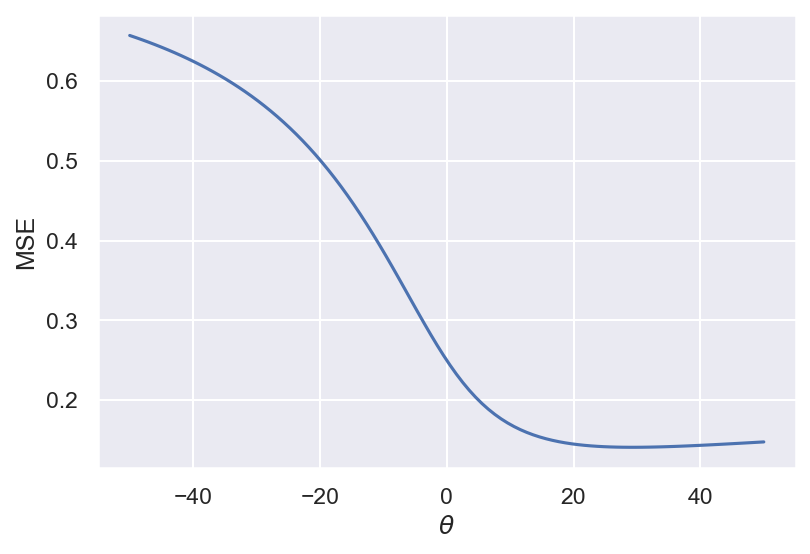

In [31]:
thetas = np.linspace(-50, 50, 100)
plt.plot(thetas, [mse_loss_single_arg_nba(theta) for theta in thetas])
plt.ylabel('MSE')
plt.xlabel(r'$\theta$');

In [32]:
minimize(mse_loss_single_arg_nba, x0 = 0)

      fun: 0.1410579018493021
 hess_inv: array([[12719.28786409]])
      jac: array([-8.78982246e-06])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 7
     njev: 12
   status: 0
  success: True
        x: array([29.12969851])

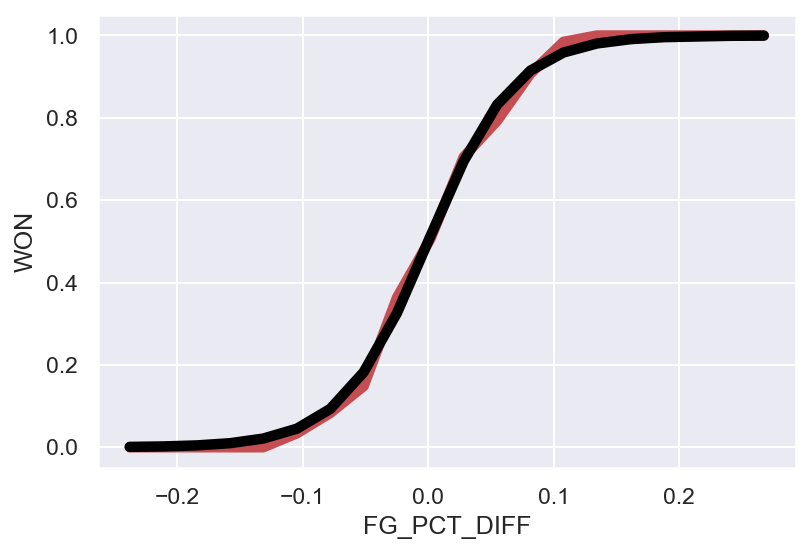

In [33]:
plt.plot(win_rates_by_bin, 'r', linewidth = 5);
x = win_rates_by_bin.index
plt.plot(x, sigma(x * 29.13), 'black', linewidth = 5);
plt.xlabel('FG_PCT_DIFF')
plt.ylabel('WON');

So squared loss worked just fine here. But that won't always be the case! Consider this manufacturered example.

In [34]:
rand_x = np.array([[-0.04185564],
       [ 0.12799961],
       [-0.09528101],
       [-0.0058139 ],
       [ 0.0870956 ]])

rand_y = np.array([[0],
       [0],
       [1],
       [0],
       [1]])

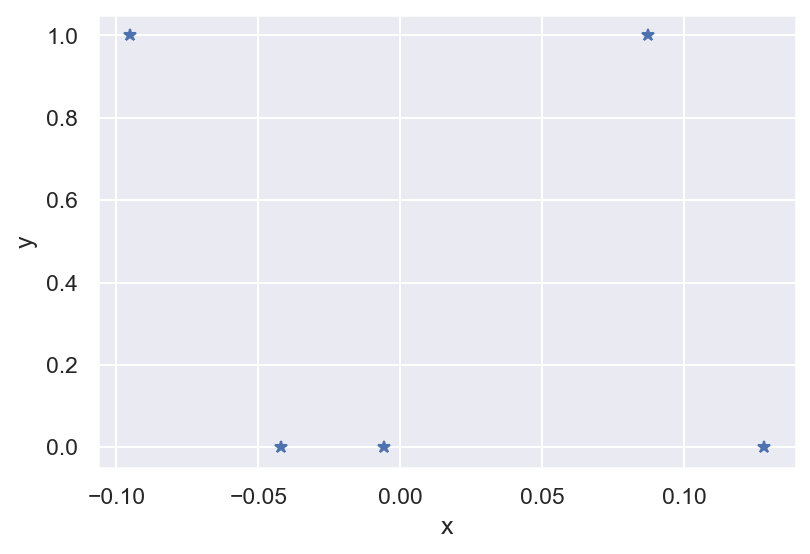

In [35]:
plt.plot(rand_x, rand_y, 'b*')
plt.xlabel('x')
plt.ylabel('y');

In [36]:
def mse_loss_single_arg_toy(theta):
    x = rand_x
    y_obs = rand_y
    y_hat = sigma(x * theta)
    return np.mean((y_obs - y_hat)**2)

In [37]:
mse_loss_single_arg_toy(10)

0.3226572801334151

Let's plot the loss surface for this toy data using squared loss with the model $\hat{y} = \sigma(\theta x)$, where $\theta$ and $x$ are both scalars.

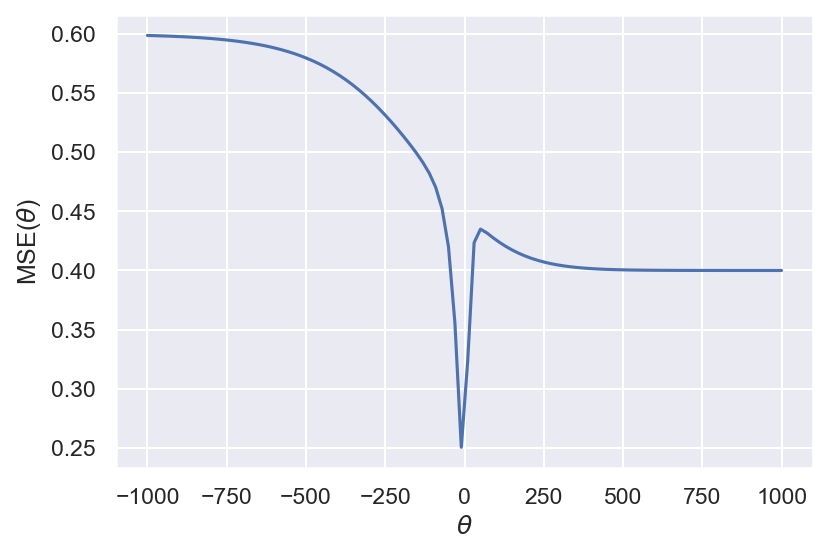

In [38]:
thetas = np.linspace(-1000, 1000, 100)
plt.plot(thetas, [mse_loss_single_arg_toy(theta) for theta in thetas])
plt.ylabel(r'MSE($\theta$)')
plt.xlabel(r'$\theta$');

This loss surface is not convex! Depending on where we start our optimization search, we'll end up with different results. Let's explore with `scipy.optimize.minimize`.

In [39]:
best_theta = minimize(mse_loss_single_arg_toy, x0 = 0)["x"][0]
best_theta

-4.801981341432673

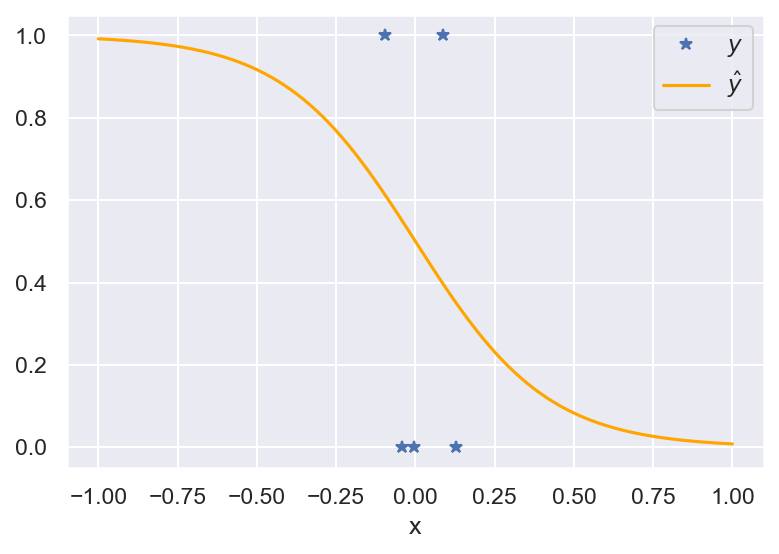

In [40]:
plt.plot(rand_x, rand_y, 'b*')
xs = np.linspace(-1, 1, 100)
plt.plot(xs, sigma(xs * best_theta), color='orange')
plt.xlabel('x')
plt.legend(['$y$', '$\hat{y}$']);

In [41]:
best_theta_2 = minimize(mse_loss_single_arg_toy, x0 = 500)["x"][0]
best_theta_2

500.0

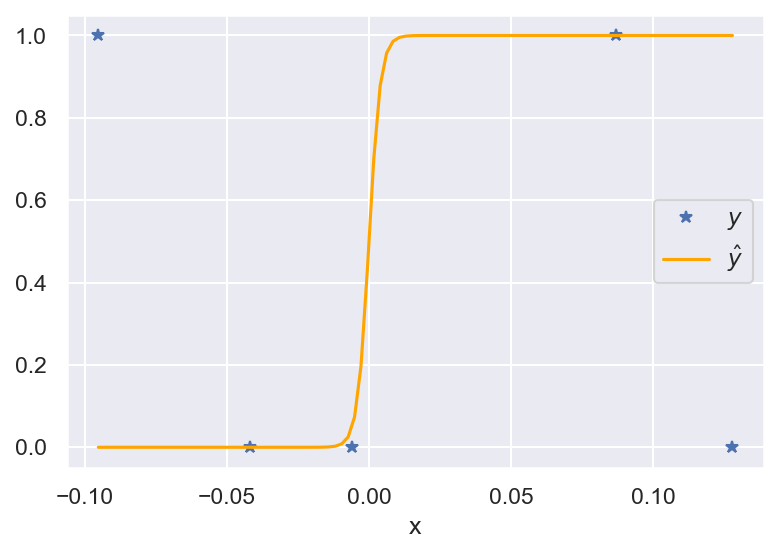

In [42]:
plt.plot(rand_x, rand_y, 'b*')
xs = np.linspace(min(rand_x), max(rand_x), 100)
plt.plot(xs, sigma(xs * best_theta_2), color='orange')
plt.xlabel('x')
plt.legend(['$y$', '$\hat{y}$']);

Not only is it not convex, leading to the weird issues above, but squared loss just isn't well-suited for a probability task. Since $\hat{y_i}$ is between 0 and 1, and $y_i$ is either 0 or 1, the squared loss for a single point $(y_i - \hat{y_i})^2$ is bounded between 0 and 1.

What this means in practice: even if our prediction is terrible, the squared loss is never that large.

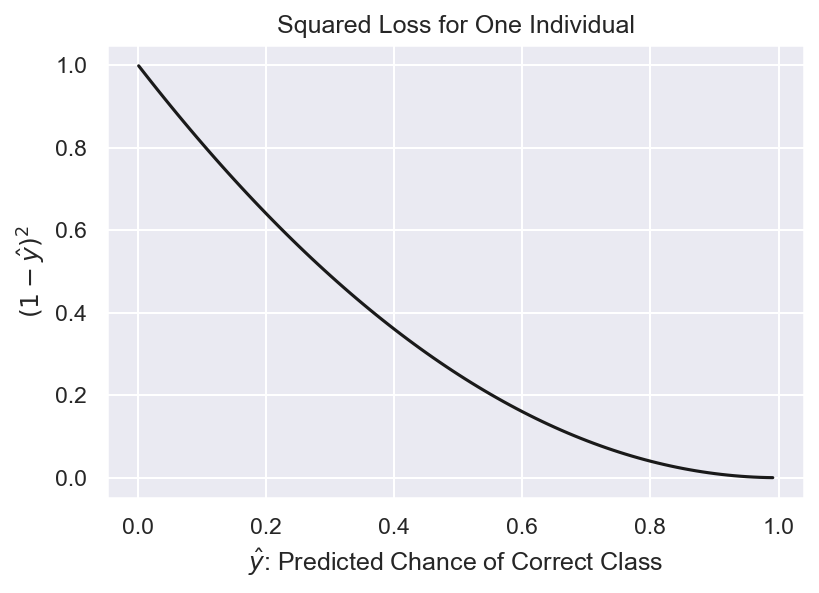

In [43]:
y_hat = np.arange(0.001, 0.999, 0.01)
loss = (1 - y_hat)**2
plt.plot(y_hat, loss, color='k')
plt.xlabel('$\hat{y}$: Predicted Chance of Correct Class')
plt.ylabel('$(1 - \hat{y})^2$')
plt.title('Squared Loss for One Individual');

## Motivating Cross-Entropy Loss

Let's look at a new loss, called the log loss, for when our true observation is 1.

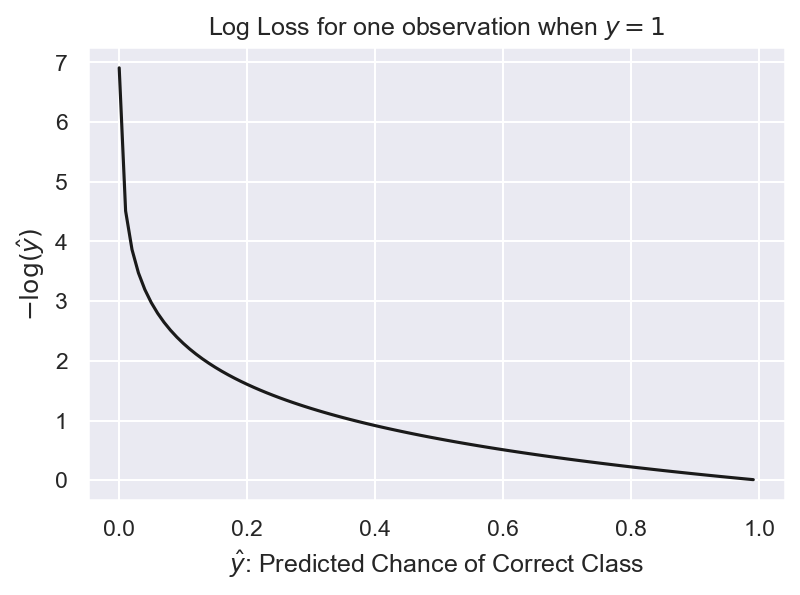

In [44]:
y_hat = np.arange(0.001, 0.999, 0.01)
loss = -np.log(y_hat)
plt.plot(y_hat, loss, color='k')
plt.xlabel('$\hat{y}$: Predicted Chance of Correct Class')
plt.ylabel('$-\log(\hat{y})$')
plt.title('Log Loss for one observation when $y = 1$');

We can see that this penalizes wrong predictions far more than squared loss does.

How to read this plot: Suppose the observation we're trying to predict is actually in class 1. If our model gives an 80% chance of being in class 1, the loss is relatively small (around 0.25). 

If we give only a 40% of being in class 1, the loss is larger (around 1).

If we give only a 5% chance of being in class 1, the loss is 3.

And if we give a 0% chance of being in class 1, the loss is infinite.

What about when the true observation is 0?

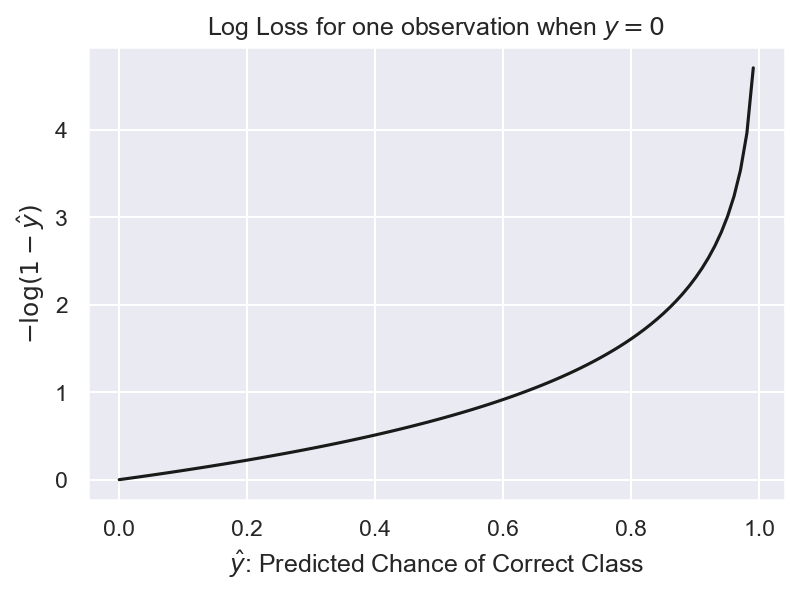

In [45]:
y_hat = np.arange(0.001, 0.999, 0.01)
loss = -np.log(1 - y_hat)
plt.plot(y_hat, loss, color='k')
plt.xlabel('$\hat{y}$: Predicted Chance of Correct Class')
plt.ylabel('$-\log(1 - \hat{y})$')
plt.title('Log Loss for one observation when $y = 0$');

Much of the formal derivation is in the slides. But the equation for cross-entropy loss for a single observation is

$$\textrm{loss} = -y \log(\hat{y}) - (1-y)\log(1-\hat{y})$$

For us, since $\hat{y} = \sigma(x^T \theta)$, the expression for average cross-entropy loss is

$$R(\theta) = -\frac{1}{n} \sum_{i = 1}^n \big(y_i \log (\sigma(\mathbb{X}_i^T \theta)) + (1 - y_i) \log (1 - \sigma(\mathbb{X}_i^T \theta))\big)$$

Let's look at the loss surface for average cross-entropy loss, on our toy data from before.

In [46]:
def cross_entropy(y, yhat):
    return - y * np.log(yhat) - (1 - y) * np.log(1 - yhat)

In [47]:
def mce_loss_single_arg_toy(theta):
    x = rand_x
    y_obs = rand_y
    y_hat = sigma(x * theta)
    return np.mean(cross_entropy(y_obs, y_hat))

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in log

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in multiply



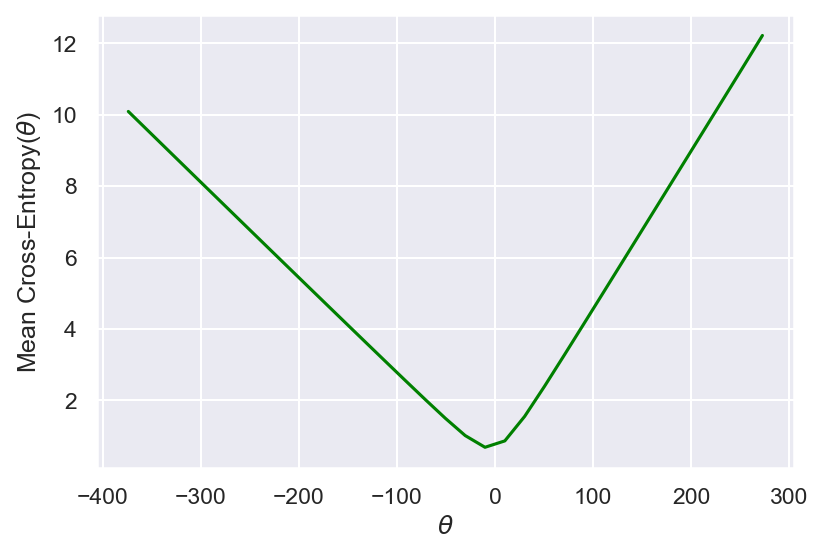

In [48]:
thetas = np.linspace(-1000, 1000, 100)
plt.plot(thetas, [mce_loss_single_arg_toy(theta) for theta in thetas], color = 'green')
plt.ylabel(r'Mean Cross-Entropy($\theta$)')
plt.xlabel(r'$\theta$');

In [49]:
best_theta_mce = minimize(mce_loss_single_arg_toy, x0 = 0)["x"][0]
best_theta_mce

-5.213601516313596

We see the resulting optimal $\hat{\theta}$ is slightly different than the one that minimized MSE:

In [50]:
best_theta

-4.801981341432673

And lastly, we can determine the $\hat{\theta}$ that minimizes mean cross-entropy loss for our NBA dataset from earlier:

In [51]:
def mce_loss_single_arg_nba(theta):
    x = games["FG_PCT_DIFF"]
    y_obs = games["WON"]
    y_hat = sigma(theta * x)
    return np.mean(cross_entropy(y_obs, y_hat))

In [52]:
best_theta_mce_nba = minimize(mce_loss_single_arg_nba, x0 = 0)["x"][0]
best_theta_mce_nba

30.57909499352484

Again, this is different than the $\hat{\theta}$ that minimizes mean squared error for the NBA dataset:

In [53]:
minimize(mse_loss_single_arg_nba, x0 = 0)["x"][0]

29.129698511291576

## Predicting Probabilities

We can manually call `scipy.optimize.minimize` to determine the model parameters that minimize average cross-entropy loss, as we did above. We can then predict probabilities.

In [54]:
best_theta_mce_nba = minimize(mce_loss_single_arg_nba, x0 = 0)["x"][0]
best_theta_mce_nba

30.57909499352484

In [55]:
def predict_probabilities(X, theta):
    return sigma(X * theta)

In [56]:
predict_probabilities(games['FG_PCT_DIFF'], best_theta_mce_nba)

GAME_ID
21700001    0.182668
21700002    0.834891
21700003    0.285493
21700004    0.777947
21700005    0.783185
              ...   
21701226    0.996919
21701227    0.891867
21701228    0.627111
21701229    0.059967
21701230    0.048978
Name: FG_PCT_DIFF, Length: 1230, dtype: float64

Once again, `scikit-learn` can do this for us.

The `lm.LogisticRegression` model is what we want to use here. In order to recreate our specific model, there are a few parameters we need to set:
- `penalty = 'none'`: by default, `lm.LogisticRegression` uses regularization. This is generally a good idea, but we haven't yet covered regularization with logistic regression (next time!).
- `fit_intercept = False`: our toy model does not currently have an intercept term.
- `solver = 'lbgfs'`: need to specify a numerical optimization routine for the model (similar to gradient descent). `lbfgs` is one such type, and it's the new default in `scikit-learn`.

In [57]:
model = lm.LogisticRegression(penalty = 'none', fit_intercept = False, solver = 'lbfgs')

In [59]:
model.fit(games[['FG_PCT_DIFF']], games['WON'])

LogisticRegression(fit_intercept=False, penalty='none')

We can see that the optimal theta (here there's just one, because our model only has one feature) found via `scikit-learn` is the same that we found manually before. (Small deviations due to numerical precision issues.)

In [60]:
model.coef_

array([[30.57950163]])

In [61]:
best_theta_mce_nba

30.57909499352484

`scikit-learn` has a built-in `.predict_proba` method that allows us to get the predicted probabilities under our model.

In [62]:
model.predict_proba([[0.1]])

array([[0.04487548, 0.95512452]])

This is saying that if `FG_PCT_DIFF = 0.1`, that is, if you shoot 10% better than your opponent, there is a 95.5% chance you will win.

We can also apply this to our entire training set at once.

In [63]:
model.predict_proba(games[['FG_PCT_DIFF']])

array([[0.81733506, 0.18266494],
       [0.16510648, 0.83489352],
       [0.71450899, 0.28549101],
       ...,
       [0.37288695, 0.62711305],
       [0.94003495, 0.05996505],
       [0.95102413, 0.04897587]])

In [64]:
model.predict_proba(games[['FG_PCT_DIFF']])[:, 1]

array([0.18266494, 0.83489352, 0.28549101, ..., 0.62711305, 0.05996505,
       0.04897587])

These values are the same as we computed manually above, as well!

In [65]:
predict_probabilities(games['FG_PCT_DIFF'], best_theta_mce_nba)

GAME_ID
21700001    0.182668
21700002    0.834891
21700003    0.285493
21700004    0.777947
21700005    0.783185
              ...   
21701226    0.996919
21701227    0.891867
21701228    0.627111
21701229    0.059967
21701230    0.048978
Name: FG_PCT_DIFF, Length: 1230, dtype: float64

## Making Classifications

`scikit-learn` also has an in-built `.predict` method. Let's see what it does:

In [66]:
model.predict(games[['FG_PCT_DIFF']])

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

How did it come up with these 1s and 0s?